# Comparing segmentations

This tutorial aims to show how testing multiple segmentation methods (e.g. Cellpose/Baysor/Comseg) or different set of segmentation parameters to compare them and find the best segmentation.

We will run three segmentations, and compare them: Cellpose with two sets of parameters, and also Baysor.

In [1]:
import sopa
import spatialdata

As usual, we will show this example on a toy dataset.

In [2]:
sdata_full = sopa.io.toy_dataset()

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell


## Cropping your data

This step is optional, although recommended. Indeed, cropping the data allows to quickly run multiple segmentation methods with multiple parameters, and compare them. Afterwards, you can keep the best segmentation method/parameters, and run it on the full dataset.

In [4]:
sdata_full

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
└── Shapes
      └── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

Here, we subset our `sdata_full` object based on a bounding from of width `1000` pixels.
You can look at the above coordinates to choose an appropriate bounding box.

Then, we save this crop as a new `.zarr` directory.

In [5]:
sdata = sdata_full.query.bounding_box(
    axes=["y", "x"], min_coordinate=[0, 0], max_coordinate=[1000, 1000], target_coordinate_system="global"
)

sdata.write("subset.zarr")
sdata = spatialdata.read_zarr("subset.zarr") # read the data from the zarr directory

INFO     The Zarr backing store has been changed from None the new file path: subset.zarr                          


## Creating the patches

As usual, we create the patches for the segmentation.

In [6]:
sopa.make_image_patches(sdata)
sopa.make_transcript_patches(sdata)

[INFO] (sopa.patches._patches) 1 patches were added to sdata['image_patches']


[########################################] | 100% Completed | 106.04 ms


[INFO] (sopa.patches._transcripts) 1 patche(s) were added to sdata['transcripts_patches']


## Running multiple segmentations

We run three segmentations:
- Cellpose on DAPI only, with `diameter=35`
- Cellpose on DAPI and CK, with `diameter=15`
- Baysor, with `scale=2` microns (expected cell radius).

Note that we use `key_added` to precise the name that we want to give to each segmentation.

In [ ]:
sopa.segmentation.cellpose(sdata, "DAPI", diameter=35, key_added="cellpose_DAPI_35")

sopa.segmentation.cellpose(sdata, ["DAPI", "CK"], diameter=15, key_added="cellpose_DAPI_CK_15")

sopa.segmentation.baysor(sdata, scale=2, key_added="baysor_scale_2")

Now, inside the shapes, with all our three segmentations: `'cellpose_DAPI_35'`, `'cellpose_DAPI_CK_15'`, and `'baysor_scale_2'`.

In [9]:
list(sdata.shapes.keys())

['cells',
 'image_patches',
 'transcripts_patches',
 'cellpose_DAPI_35',
 'cellpose_DAPI_CK_15',
 'baysor_scale_2']

Then, we can aggregate the transcripts inside the cells. Since we have multiple shapes layers, we need to precise `shapes_key`.

> Also, we can set a specific name for the table that will be created (via `key_added`), or keep `key_added=None` which will use the name `"{shapes_key}_table"` by default.

In [ ]:
sopa.aggregate(sdata, shapes_key="cellpose_DAPI_35", key_added=None)
sopa.aggregate(sdata, shapes_key="cellpose_DAPI_CK_15", key_added=None)
sopa.aggregate(sdata, shapes_key="baysor_scale_2", key_added=None)

Now, we have one table for each shape layer:

In [11]:
list(sdata.tables.keys())

['table',
 'cellpose_DAPI_35_table',
 'cellpose_DAPI_CK_15_table',
 'baysor_scale_2_table']

## Comparison

Now, we can compare the different shapes / tables to see which segmentation method or which parameters were the best. We show some simple analysis below that can help us decide between the three.

Feel free to perform more sophisticated quality checks.

In [12]:
# the different table names that were created
table_names = ['cellpose_DAPI_35_table', 'cellpose_DAPI_CK_15_table', 'baysor_scale_2_table']

### Visual comparison

We can plot the images / shapes / transcripts to visually find the best segmentation. Here, we can definitely see that `"cellpose_DAPI_CK_15"` is not good, as the cells are very small. It appears that `diameter=15` was not a good Cellpose parameter for this image.

In [13]:
import spatialdata_plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].


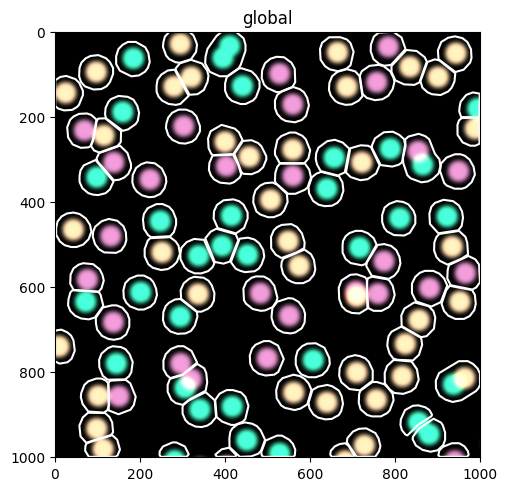

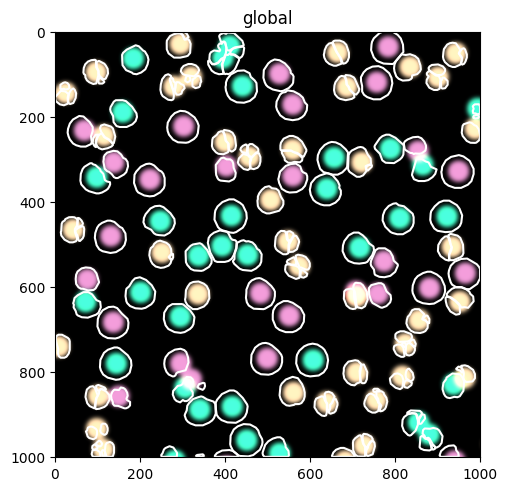

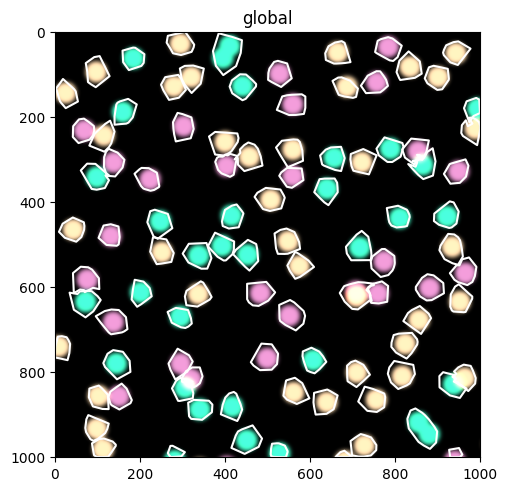

In [14]:
# Cellpose on DAPI with diameter 35
sdata\
    .pl.render_images("image")\
    .pl.render_shapes("cellpose_DAPI_35", fill_alpha=0, outline_color="#fff", outline_alpha=1)\
    .pl.show("global")

# Cellpose on DAPI and CK with diameter 15
sdata\
    .pl.render_images("image")\
    .pl.render_shapes("cellpose_DAPI_CK_15", fill_alpha=0, outline_color="#fff", outline_alpha=1)\
    .pl.show("global")

# Baysor with scale 2
sdata\
    .pl.render_images("image")\
    .pl.render_shapes("baysor_scale_2", fill_alpha=0, outline_color="#fff", outline_alpha=1)\
    .pl.show("global")

### Tables comparison

We can also compute some simple quality controls, such as the mean transcript count per cell, or the distribution of transcript count. Again, we see that cellpose with `diameter=15` was worse than the two other segmentations.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

Table: cellpose_DAPI_35_table, n_cells=95, total_count=9460, mean_count_per_cell=99.58


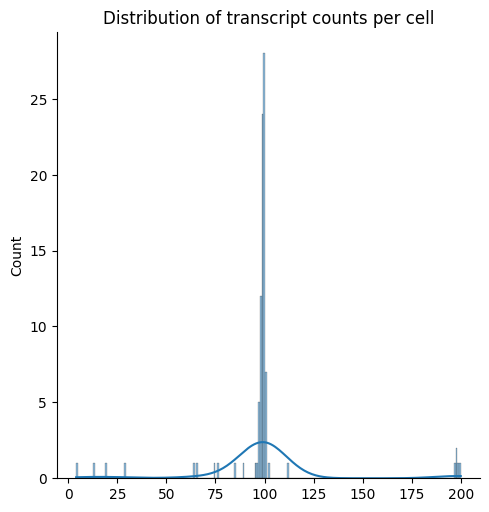

Table: cellpose_DAPI_CK_15_table, n_cells=163, total_count=8240, mean_count_per_cell=50.55


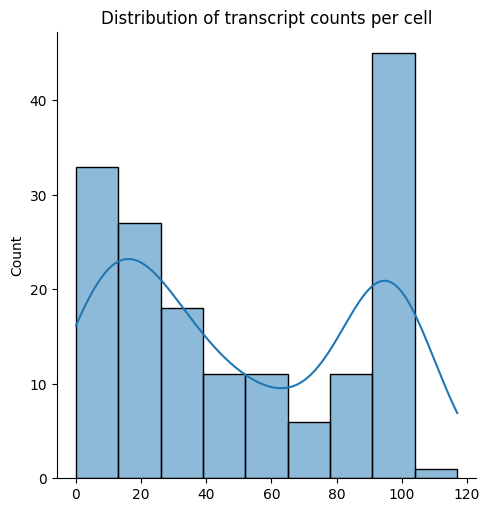

Table: baysor_scale_2_table, n_cells=96, total_count=9565, mean_count_per_cell=99.64


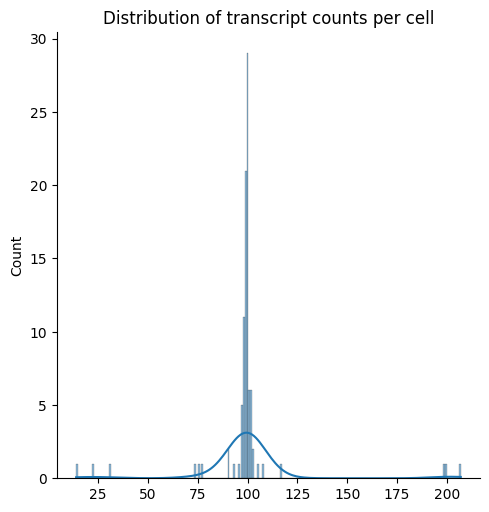

In [17]:
for name in table_names:
    adata = sdata.tables[name]
    n_cells = adata.n_obs
    total_count = adata.X.sum()
    transcript_counts = adata.X.sum(axis=1).A1
    mean_count_per_cell = transcript_counts.mean()
    
    print(f"Table: {name}, {n_cells=}, {total_count=}, {mean_count_per_cell=:.2f}")
    sns.displot(transcript_counts, kde=True)
    plt.title("Distribution of transcript counts per cell")
    plt.show()

### UMAP comparisons

We can also compute a UMAP on all tables, and look which table gives the best separation. Here, it seems that Baysor is slightly cleaner.

In [18]:
import scanpy as sc

/var/folders/rl/nsddz37s55zbfg5h7b060rlc0000gn/T/ipykernel_28535/1797552473.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


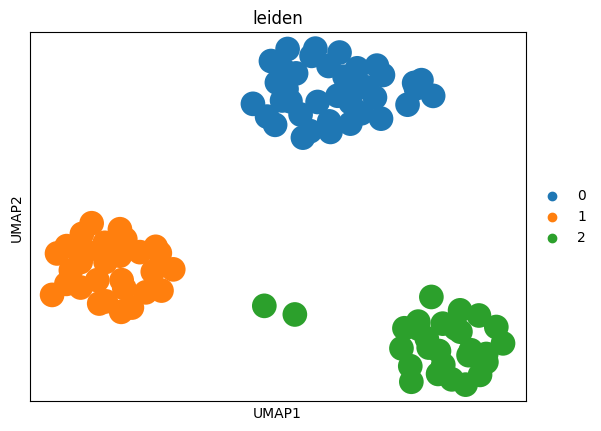

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


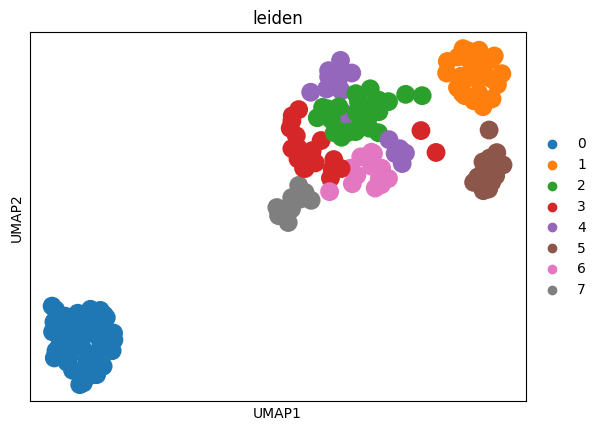

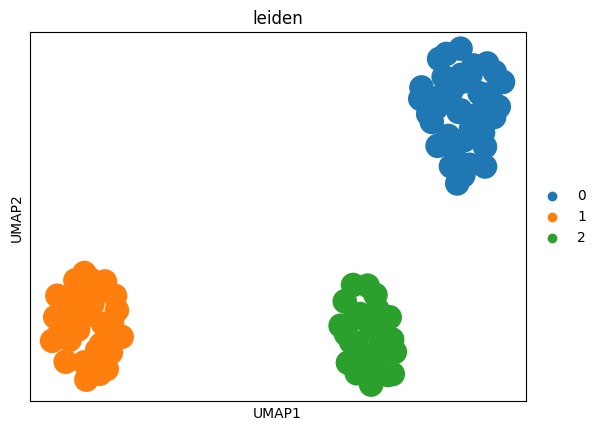

In [19]:
for name in table_names:
    adata = sdata.tables[name]
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    
    sc.pl.umap(adata, color='leiden')
    plt.show()

## Next steps

After the above comparison, you should have found the right method / parameters for your dataset.

You can now use these parameters to run Sopa on the full slide or cohort. For that, refer to the other tutorials, for instance the API or Snakemake tutorials.